Importando as bibliotecas que serão usadas para o treinamento da RNA, a obtenção de métricas e a geração de gráficos:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

In [2]:
# Imporando o dataset
dataset = pd.read_csv("ad_click_dataset.csv")
dataset.head()


,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


Descrição do dataset:

In [3]:

dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


,id,age,click
count,10000.000000,5234.000000,10000.000000
mean,5060.211400,40.197363,0.650000
std,2861.758265,13.126420,0.476993
min,5.000000,18.000000,0.000000
25%,2529.000000,29.000000,0.000000
50%,5218.000000,39.500000,1.000000
75%,7466.000000,52.000000,1.000000
max,10000.000000,64.000000,1.000000


In [4]:
dataset['gender'].value_counts()

gender
Female        1834
Male          1810
Non-Binary    1663
Name: count, dtype: int64

In [5]:
dataset['device_type'].value_counts()

device_type
Desktop    2754
Mobile     2649
Tablet     2597
Name: count, dtype: int64

In [6]:
dataset['ad_position'].value_counts()

ad_position
Bottom    2817
Top       2597
Side      2586
Name: count, dtype: int64

In [7]:
dataset['browsing_history'].value_counts()

browsing_history
Entertainment    1175
Social Media     1054
Education        1029
Shopping          984
News              976
Name: count, dtype: int64

In [8]:
dataset['time_of_day'].value_counts()

time_of_day
Morning      2126
Afternoon    2016
Evening      1958
Night        1900
Name: count, dtype: int64

In [9]:
dataset = dataset.drop(columns=['id','full_name'], axis=1)
dataset.shape

(10000, 7)

In [10]:
num_cols = dataset.select_dtypes(include=['float64', 'int64'])
cat_cols = dataset.select_dtypes(include=['object'])

print('Numeric Variables:')
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())

Numeric Variables:
['age', 'click']

Categorical Variables:
['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']


In [11]:
dataset.describe().T


,count,mean,std,min,25%,50%,75%,max
age,5234.0,40.197363,13.126420,18.0,29.0,39.5,52.0,64.0
click,10000.0,0.650000,0.476993,0.0,0.0,1.0,1.0,1.0


Quantidade de valores nulos de cada atributo:

In [12]:
dataset.isnull().sum()

age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

In [13]:
dataset[dataset.isnull().any(axis=1)]

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,NaN,Male,Desktop,Top,NaN,NaN,1
2,41.0,Non-Binary,NaN,Side,Education,Night,1
3,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
...,...,...,...,...,...,...,...
9994,NaN,Non-Binary,NaN,NaN,News,Morning,1
9995,NaN,NaN,Mobile,Top,Education,NaN,0
9996,NaN,Female,Desktop,Bottom,Entertainment,NaN,0
9997,NaN,Male,Mobile,Side,NaN,Morning,0


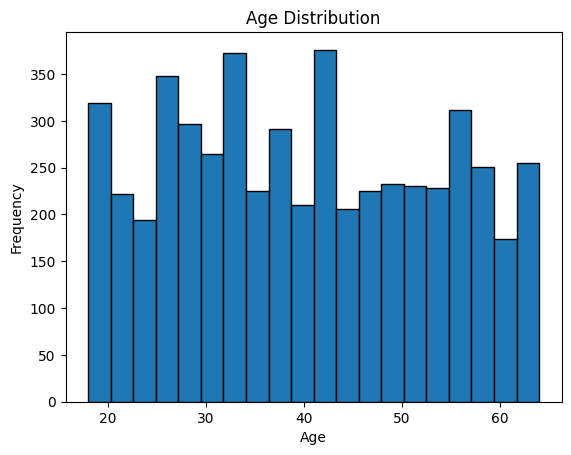

In [14]:
# Distribuição da idade 
plt.hist(dataset['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Distribuição dos clicks por classes:

C:\Users\Juliano\AppData\Local\Temp\ipykernel_4728\3147185908.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset['click'], data=dataset, palette = "Set2")


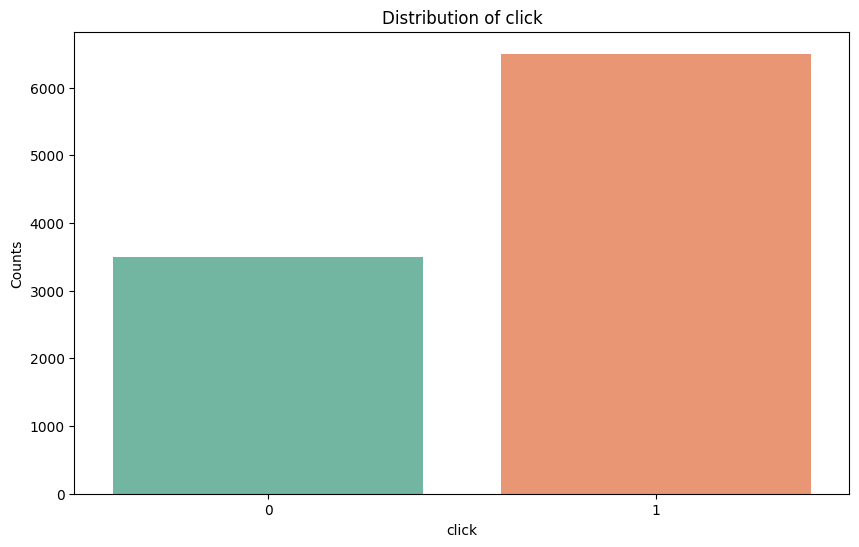

In [15]:

cor = sns.color_palette("Set2")
plt.figure(figsize=(10,6))
sns.countplot(x=dataset['click'], data=dataset, palette = "Set2")
plt.title(f'Distribution of click')
plt.xlabel('click')
plt.ylabel('Counts')
plt.show()

Tratamento dos dados:

In [16]:
# Substituindo Nan das colunas categóricas por 'Unknown'. Isso representa a falta de informação
dataset['gender'] = dataset['gender'].fillna('Unknown')
dataset['device_type'] = dataset['device_type'].fillna('Unknown')
dataset['ad_position'] = dataset['ad_position'].fillna('Unknown')
dataset['browsing_history'] = dataset['browsing_history'].fillna('Unknown')
dataset['time_of_day'] = dataset['time_of_day'].fillna('Unknown')
dataset.head(10)

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,Unknown,Desktop,Top,Shopping,Afternoon,1
1,NaN,Male,Desktop,Top,Unknown,Unknown,1
2,41.0,Non-Binary,Unknown,Side,Education,Night,1
3,34.0,Male,Unknown,Unknown,Entertainment,Evening,1
4,39.0,Non-Binary,Unknown,Unknown,Social Media,Morning,0
5,NaN,Non-Binary,Unknown,Bottom,Social Media,Evening,1
6,26.0,Female,Desktop,Top,Unknown,Unknown,1
7,40.0,Male,Mobile,Side,Unknown,Evening,0
8,NaN,Non-Binary,Mobile,Bottom,Social Media,Unknown,1
9,NaN,Unknown,Unknown,Bottom,Education,Afternoon,1


C:\Users\Juliano\AppData\Local\Temp\ipykernel_4728\2771598423.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


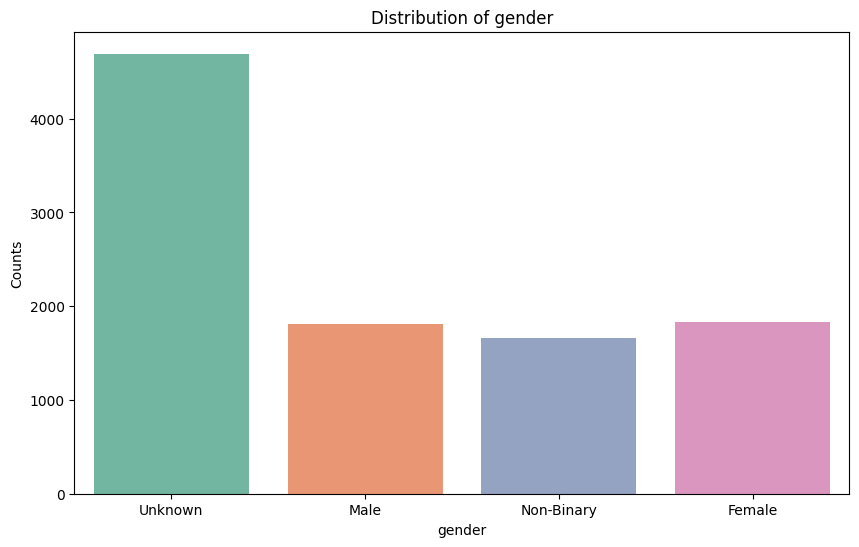

C:\Users\Juliano\AppData\Local\Temp\ipykernel_4728\2771598423.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


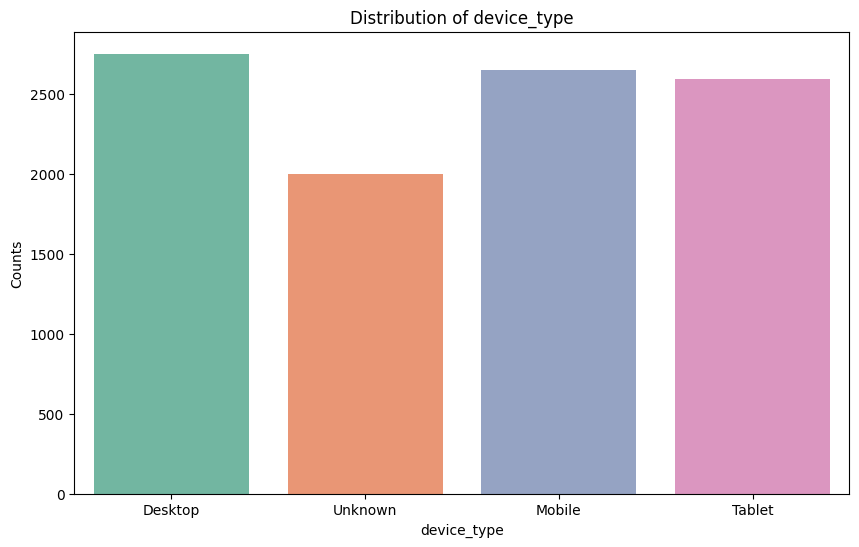

C:\Users\Juliano\AppData\Local\Temp\ipykernel_4728\2771598423.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


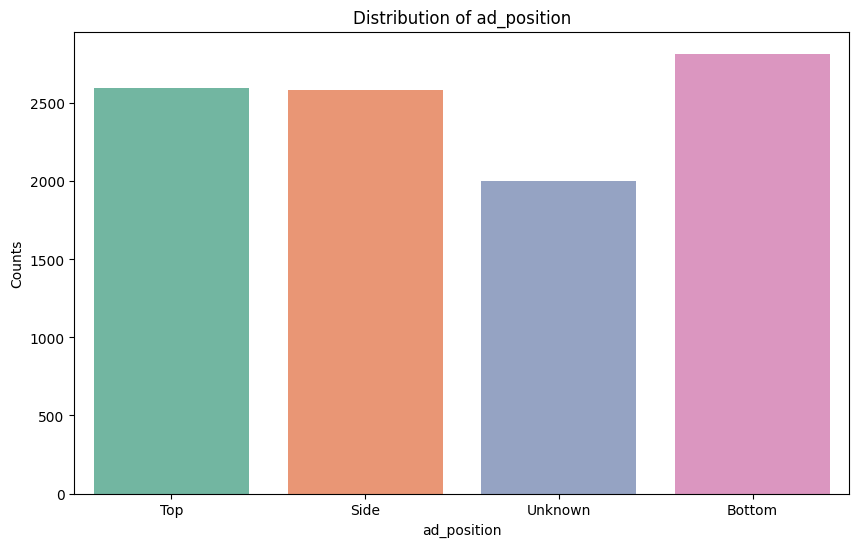

C:\Users\Juliano\AppData\Local\Temp\ipykernel_4728\2771598423.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


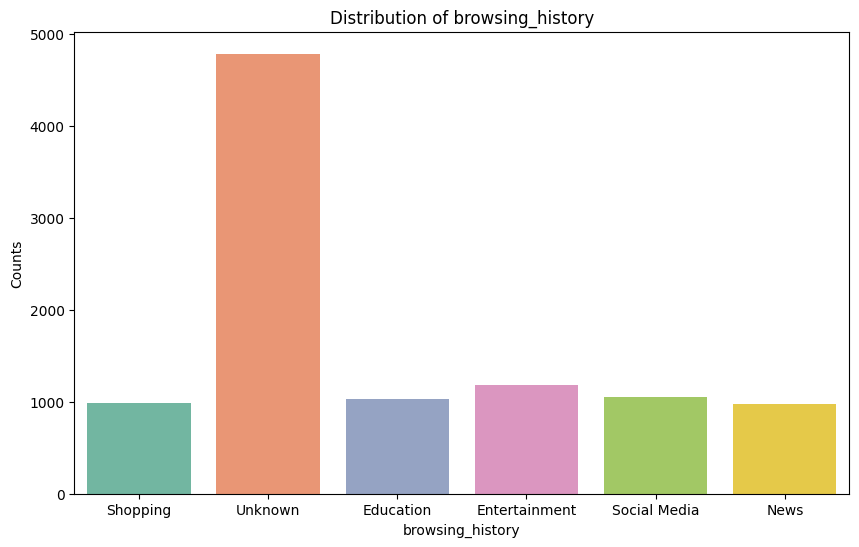

C:\Users\Juliano\AppData\Local\Temp\ipykernel_4728\2771598423.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=dataset, palette = "Set2")


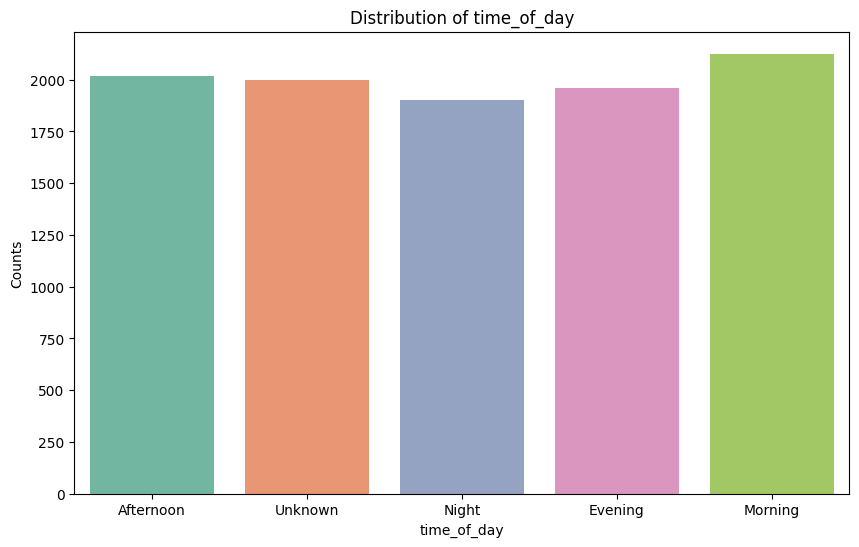

In [17]:
# Gráficos de distribuição dos atributos categóricos após a imputação de 'Unknown'
cat=['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']
cor = sns.color_palette("Set2")
for col in cat:
  plt.figure(figsize=(10,6))
  sns.countplot(x=col, data=dataset, palette = "Set2")
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Counts')
  plt.show()

In [18]:
# No atributo numérico 'age', é feita a imputação de valores usando o algoritmo K-Nearest Neighbors
def knn_impute(data, n_neighbors):   
    data_encoded = data.copy()
    
    category_mappings = {}
    for col in data_encoded.select_dtypes(include='object').columns:
        data_encoded[col] = data_encoded[col].astype('category').cat.codes
        category_mappings[col] = dict(enumerate(data[col].astype('category').cat.categories))

    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_encoded), columns=data_encoded.columns)

    for col in data.select_dtypes(include='object').columns:
        data_imputed[col] = data_imputed[col].round().astype(int).map(category_mappings[col])
        
    return data_imputed

data_imputed = knn_impute(dataset, n_neighbors=3)
data_imputed['age'] = np.floor(data_imputed['age'])
dataset = data_imputed
dataset.head(10)

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,Unknown,Desktop,Top,Shopping,Afternoon,1.0
1,52.0,Male,Desktop,Top,Unknown,Unknown,1.0
2,41.0,Non-Binary,Unknown,Side,Education,Night,1.0
3,34.0,Male,Unknown,Unknown,Entertainment,Evening,1.0
4,39.0,Non-Binary,Unknown,Unknown,Social Media,Morning,0.0
5,48.0,Non-Binary,Unknown,Bottom,Social Media,Evening,1.0
6,26.0,Female,Desktop,Top,Unknown,Unknown,1.0
7,40.0,Male,Mobile,Side,Unknown,Evening,0.0
8,28.0,Non-Binary,Mobile,Bottom,Social Media,Unknown,1.0
9,38.0,Unknown,Unknown,Bottom,Education,Afternoon,1.0


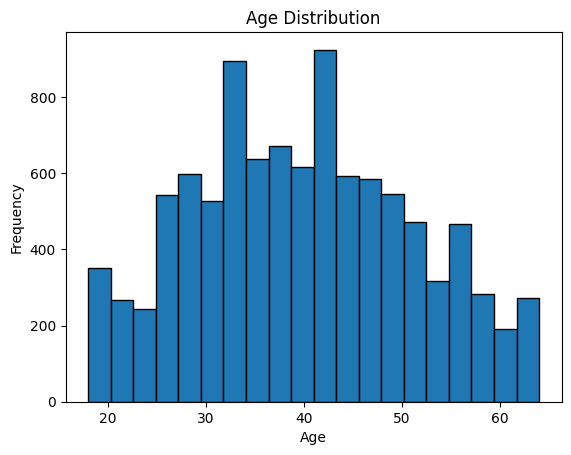

In [19]:
# Distribuição da idade após a imputação de valores
plt.hist(dataset['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

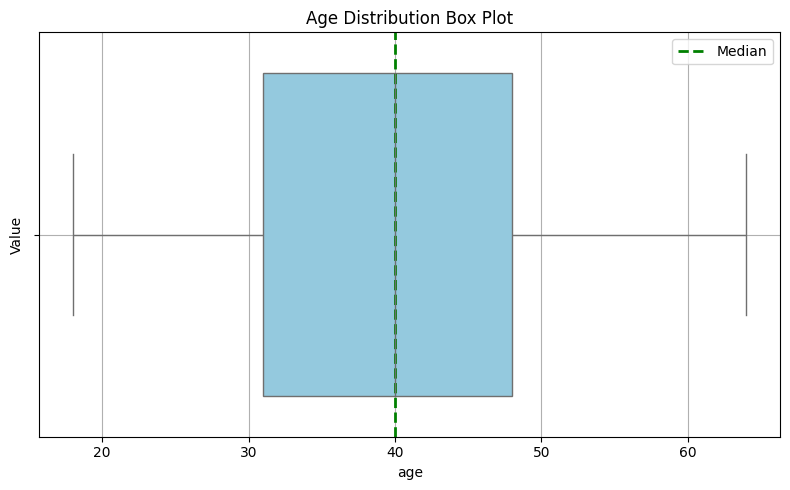

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=dataset, x="age", color='skyblue', flierprops=dict(marker='o', markersize=8, markerfacecolor='red'))
plt.title('Age Distribution Box Plot')
plt.xlabel('age')
plt.ylabel('Value')
median_age = dataset['age'].median()
plt.axvline(median_age, color='green', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Não há mais valores nulos no dataset
dataset.isnull().sum()

age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64

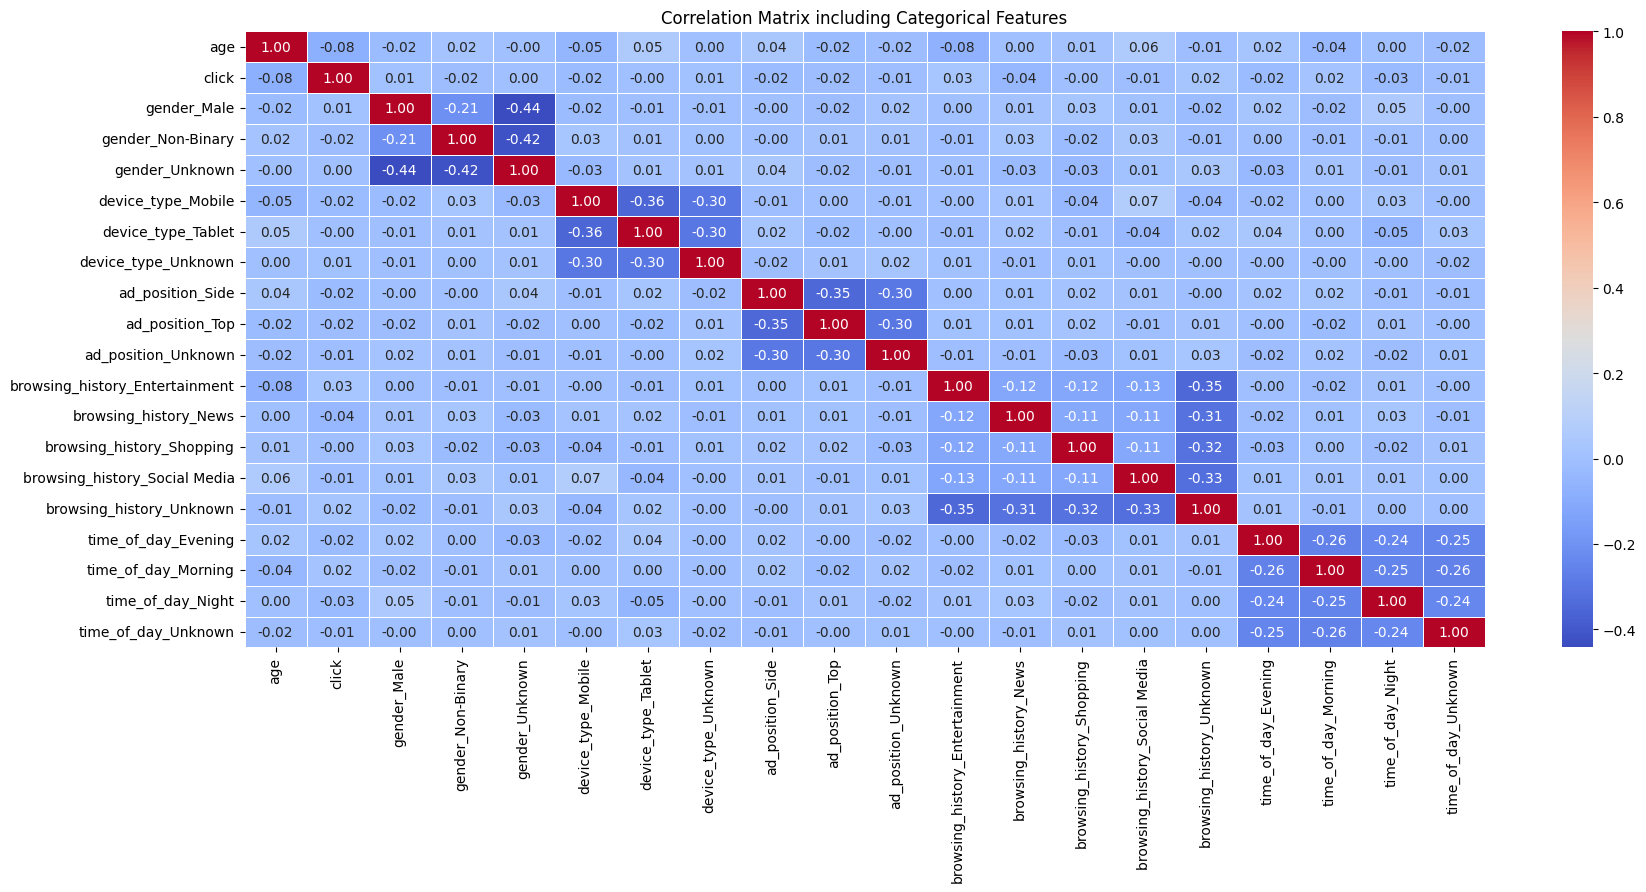

In [22]:
# Matriz de correlação
data_encoded = pd.get_dummies(dataset, drop_first=True)
corr_matrix = data_encoded.corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [23]:
# Separando as variáveis independentes (entrada) das variáveis dependendes (saída)
x = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]
x

,age,gender,device_type,ad_position,browsing_history,time_of_day
0,22.0,Unknown,Desktop,Top,Shopping,Afternoon
1,52.0,Male,Desktop,Top,Unknown,Unknown
2,41.0,Non-Binary,Unknown,Side,Education,Night
3,34.0,Male,Unknown,Unknown,Entertainment,Evening
4,39.0,Non-Binary,Unknown,Unknown,Social Media,Morning
...,...,...,...,...,...,...
9995,55.0,Unknown,Mobile,Top,Education,Unknown
9996,39.0,Female,Desktop,Bottom,Entertainment,Unknown
9997,39.0,Male,Mobile,Side,Unknown,Morning
9998,36.0,Unknown,Desktop,Unknown,Shopping,Morning


In [24]:
# Transformando os dados categóricos em numéricos utilizando o One-hot Encoding
categorical_columns = x.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(x[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
x = pd.concat([x, one_hot_df], axis=1)
x = x.drop(categorical_columns, axis=1)
print(f"Dados categóricos convertidos : \n{x}")

Dados categóricos convertidos : 
       age  gender_Female  gender_Male  gender_Non-Binary  gender_Unknown  \
0     22.0            0.0          0.0                0.0             1.0   
1     52.0            0.0          1.0                0.0             0.0   
2     41.0            0.0          0.0                1.0             0.0   
3     34.0            0.0          1.0                0.0             0.0   
4     39.0            0.0          0.0                1.0             0.0   
...    ...            ...          ...                ...             ...   
9995  55.0            0.0          0.0                0.0             1.0   
9996  39.0            1.0          0.0                0.0             0.0   
9997  39.0            0.0          1.0                0.0             0.0   
9998  36.0            0.0          0.0                0.0             1.0   
9999  44.0            0.0          1.0                0.0             0.0   

      device_type_Desktop  device_type_Mob

Preparando o treinamento da RNA:

In [36]:
# Separando o conjunto de testes e o conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35, shuffle=True, random_state=42)

# Balanceando o conjunto de treinamento
smote = SMOTE(random_state=42)
ros = RandomOverSampler(random_state = 42)
adasyn = ADASYN(random_state = 42)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape
#X_test.shape

(8406, 24)

In [402]:
# Definição do modelo MLP, 5 camadas ocultas com 46 neurônios e função de ativação ReLu. 
# Camada de saída com um neurônio e função de ativação Sigmoid
# A camada Dropout ignora aleatóriamente 20% dos neurônios
model = Sequential([
  Dense(46, activation='relu'),
  Dense(46, activation='relu'),
  Dense(46, activation='relu'),
  Dense(46, activation='relu'),
  Dense(46, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
])

model.compile(optimizer= Adam(learning_rate=0.0009), loss='binary_crossentropy', metrics=[BinaryAccuracy(threshold=0.5)])

model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))



Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.5261 - loss: 0.6893 - val_binary_accuracy: 0.6371 - val_loss: 0.6506
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.5939 - loss: 0.6684 - val_binary_accuracy: 0.5926 - val_loss: 0.6620
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.6373 - loss: 0.6412 - val_binary_accuracy: 0.5960 - val_loss: 0.6630
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6722 - loss: 0.6101 - val_binary_accuracy: 0.6283 - val_loss: 0.6548
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6979 - loss: 0.5774 - val_binary_accuracy: 0.6380 - val_loss: 0.6435
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.7222 - loss: 0.5531 - val_binary_accuracy: 0.6409 - val_loss: 0.6521
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.7399 - loss: 0.5256 - val_binary_accuracy: 0.6429 - val_loss: 0.6612

In [403]:
# Acurácia da RNA
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia: {accuracy}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7691 - loss: 0.9029
Acurácia: 0.7699999809265137


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.68      0.64      0.66      1223
         1.0       0.81      0.84      0.83      2277

    accuracy                           0.77      3500
   macro avg       0.75      0.74      0.74      3500
weighted avg       0.77      0.77      0.77      3500



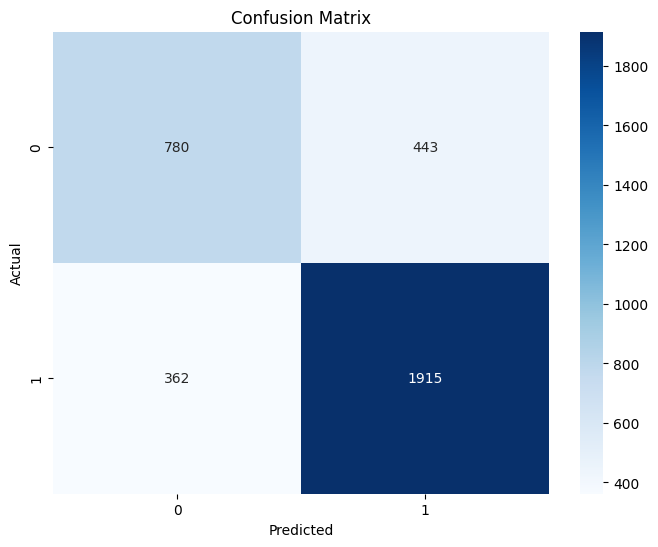

In [404]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
# Exibe as métricas
print(classification_report(y_test, y_pred))

# Exibe a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


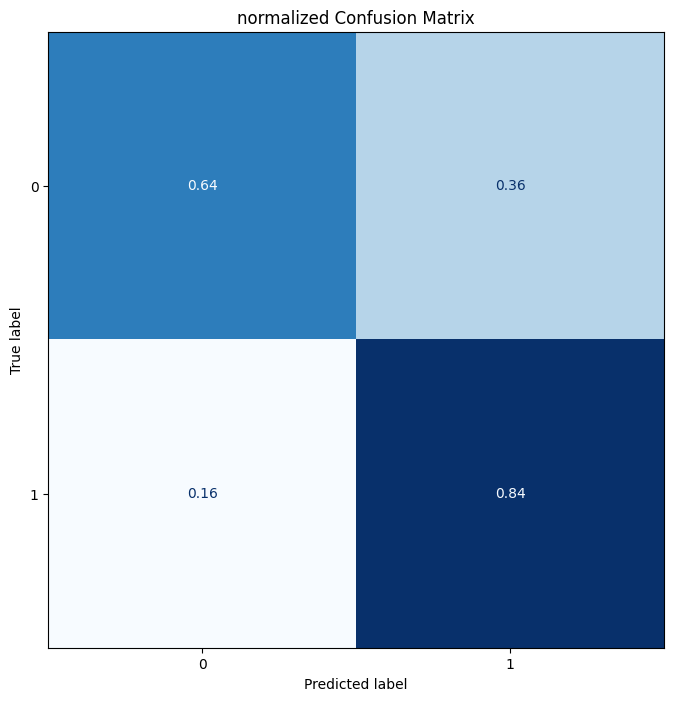

0.77

In [405]:

cm=confusion_matrix(y_test,y_pred,normalize='true')
fig,ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues',values_format='.2f',ax=ax,colorbar=False)
plt.title('normalized Confusion Matrix')
plt.show()

accuracy_score(y_test, y_pred)

In [406]:
# Salva o modelo
model.save('adclick_model.keras')
# Carrega o modelo
model = load_model('adclick_model.keras')
model.summary()


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_257 (Dense)               │ (None, 46)             │         1,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 46)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 1)              │            47 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,537 (115.38 KB)

 Trainable params: 9,845 (38.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,692 (76.93 KB)

Predição a partir dos dados de testes:

In [407]:
y_predi = model.predict(X_test)
random_idx = np.random.randint(0, X_test.shape[0])
linha_teste = X_test[random_idx].reshape(1, -1)  
predicao = model.predict(linha_teste)


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Mais métricas:

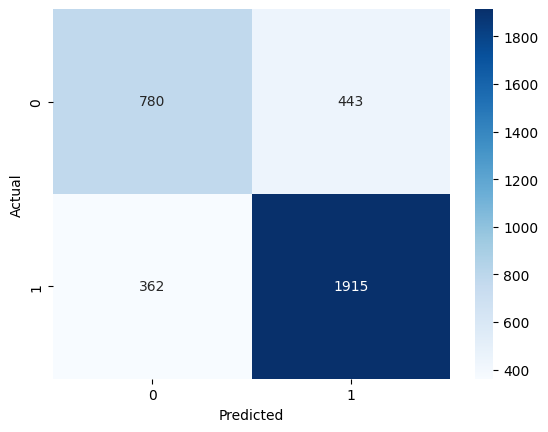

In [408]:
cm = confusion_matrix(y_test, y_predi.round())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

A ROC Curve avalia o desempenho de um modelo de classificação binária, mostrando a relação entre a taxa de falsos positivos. O objetivo é avaliar quão bem o modelo consegue separar as classes (0 e 1), quanto mais perto do eixo y, melhor é a avaliação. Já AUC (Area Under the Curve) é exibida como uma métrica que quantifica a performance geral: quanto mais próximo de 1, melhor a performance.

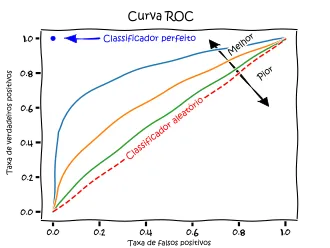

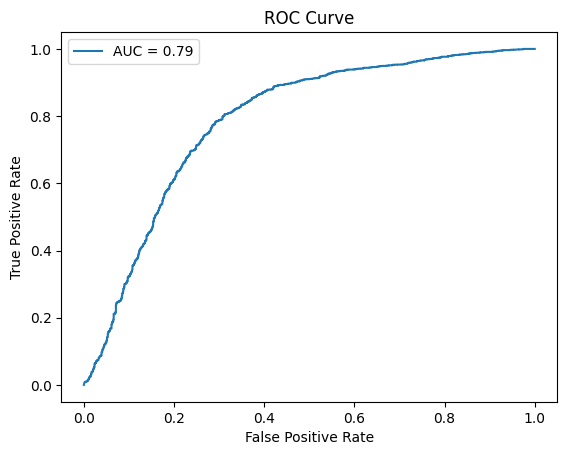

In [409]:
fpr, tpr, _ = roc_curve(y_test, y_predi)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

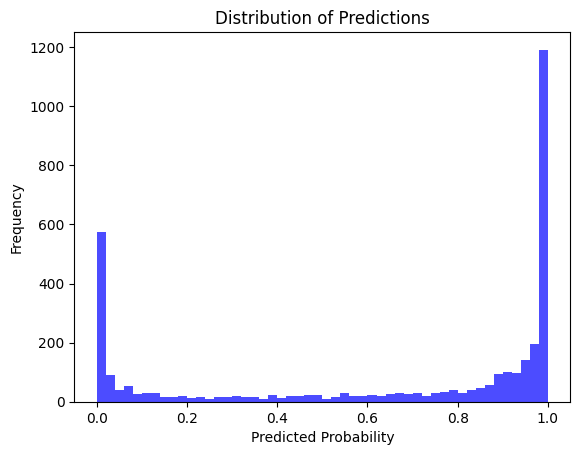

In [410]:
plt.hist(y_predi, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

In [411]:
# Simulando uma entrada a partir do conjunto de teste
random_idx = np.random.randint(0, X_test.shape[0])
new_input = X_test[random_idx].reshape(1, -1)  

predicao = model.predict(new_input)
predicted_class = 1 if predicao >= 0.5 else 0

original_class = y_test.iloc[random_idx]  

print(f"Classe prevista: {predicted_class}")
print(f"Classe original: {original_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Classe prevista: 0
Classe original: 0.0
